In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import optuna
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [3]:
data = pd.read_csv("../train.csv")
test_df = pd.read_csv("../test.csv")

sub_df = pd.read_csv("../sample_submission.csv")

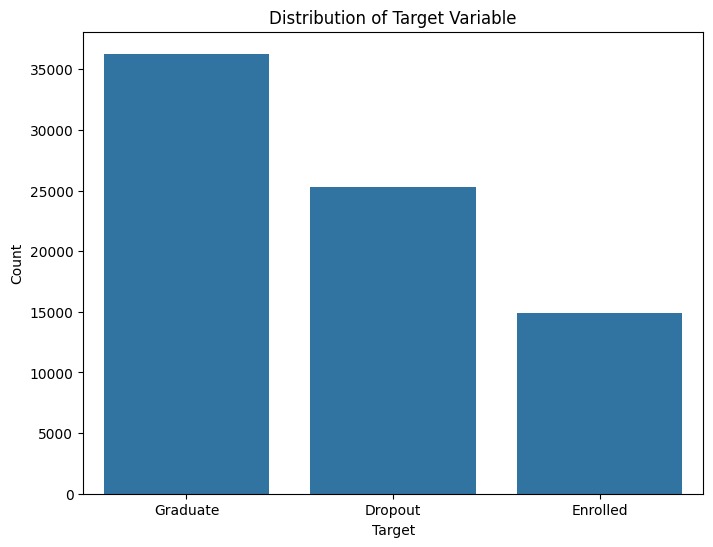

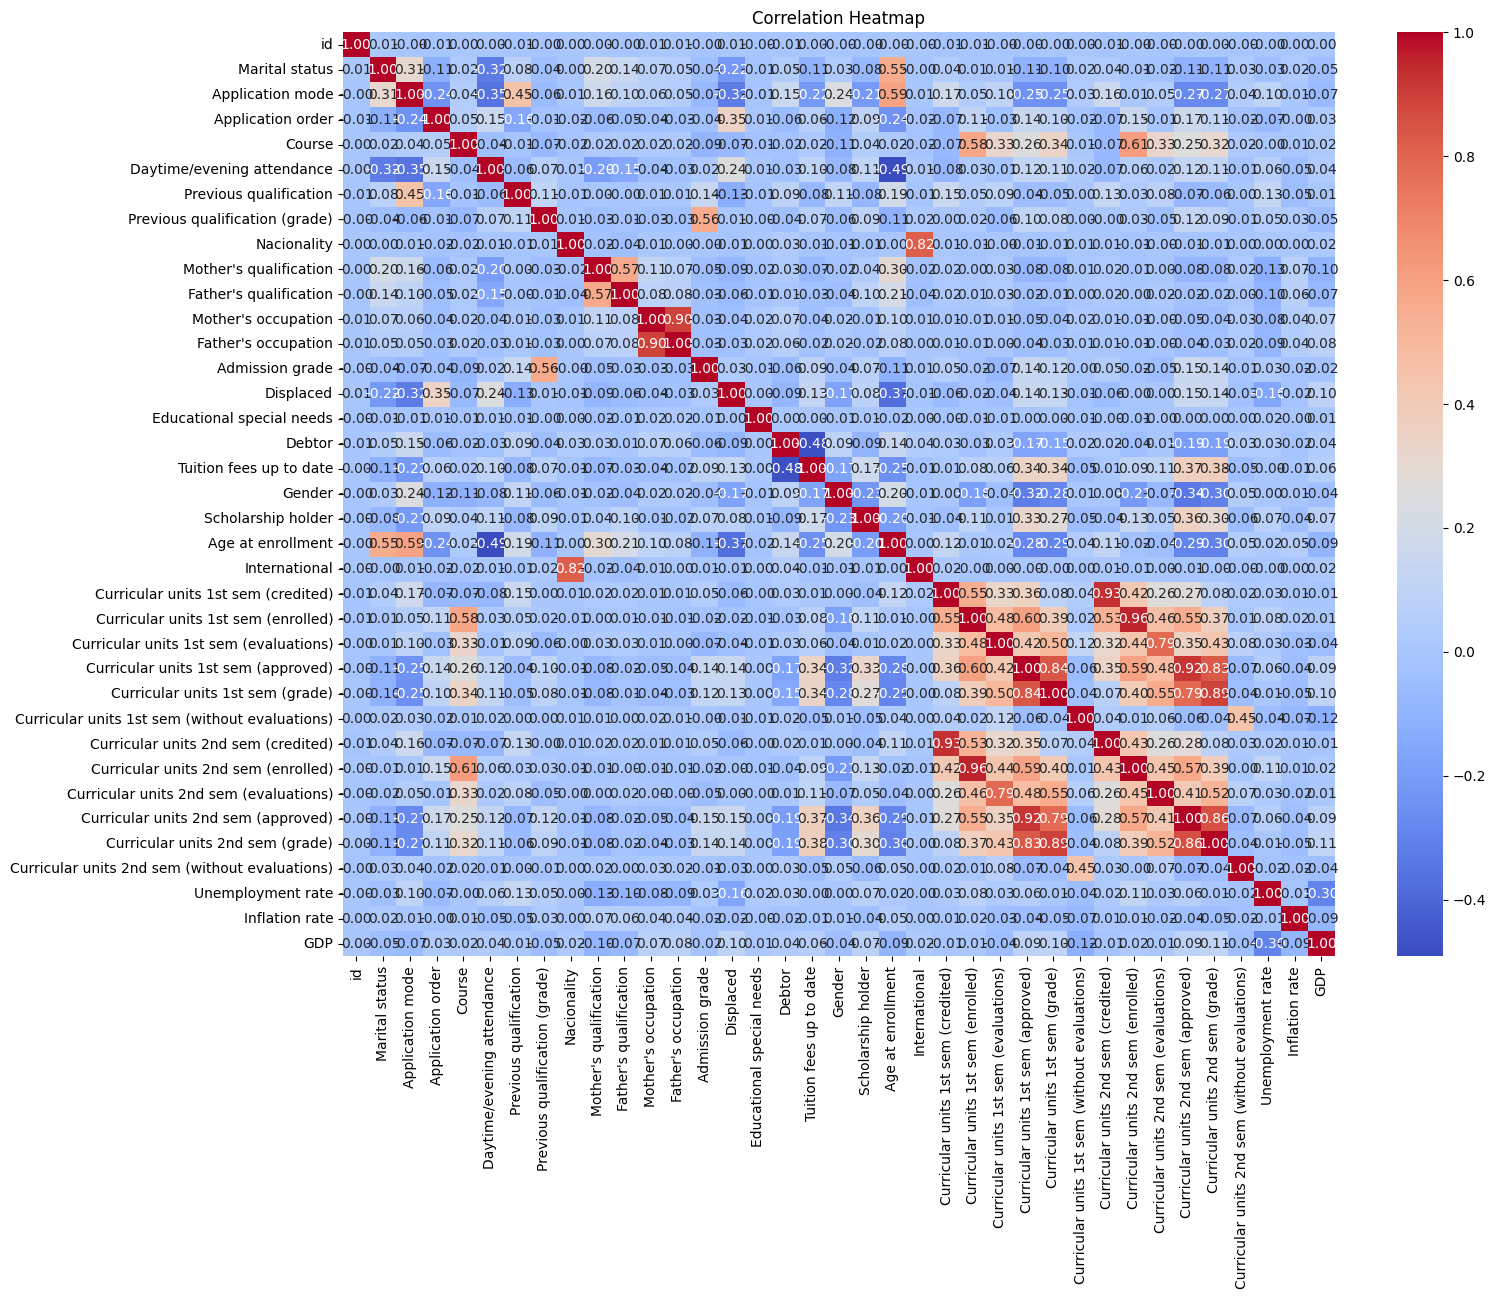

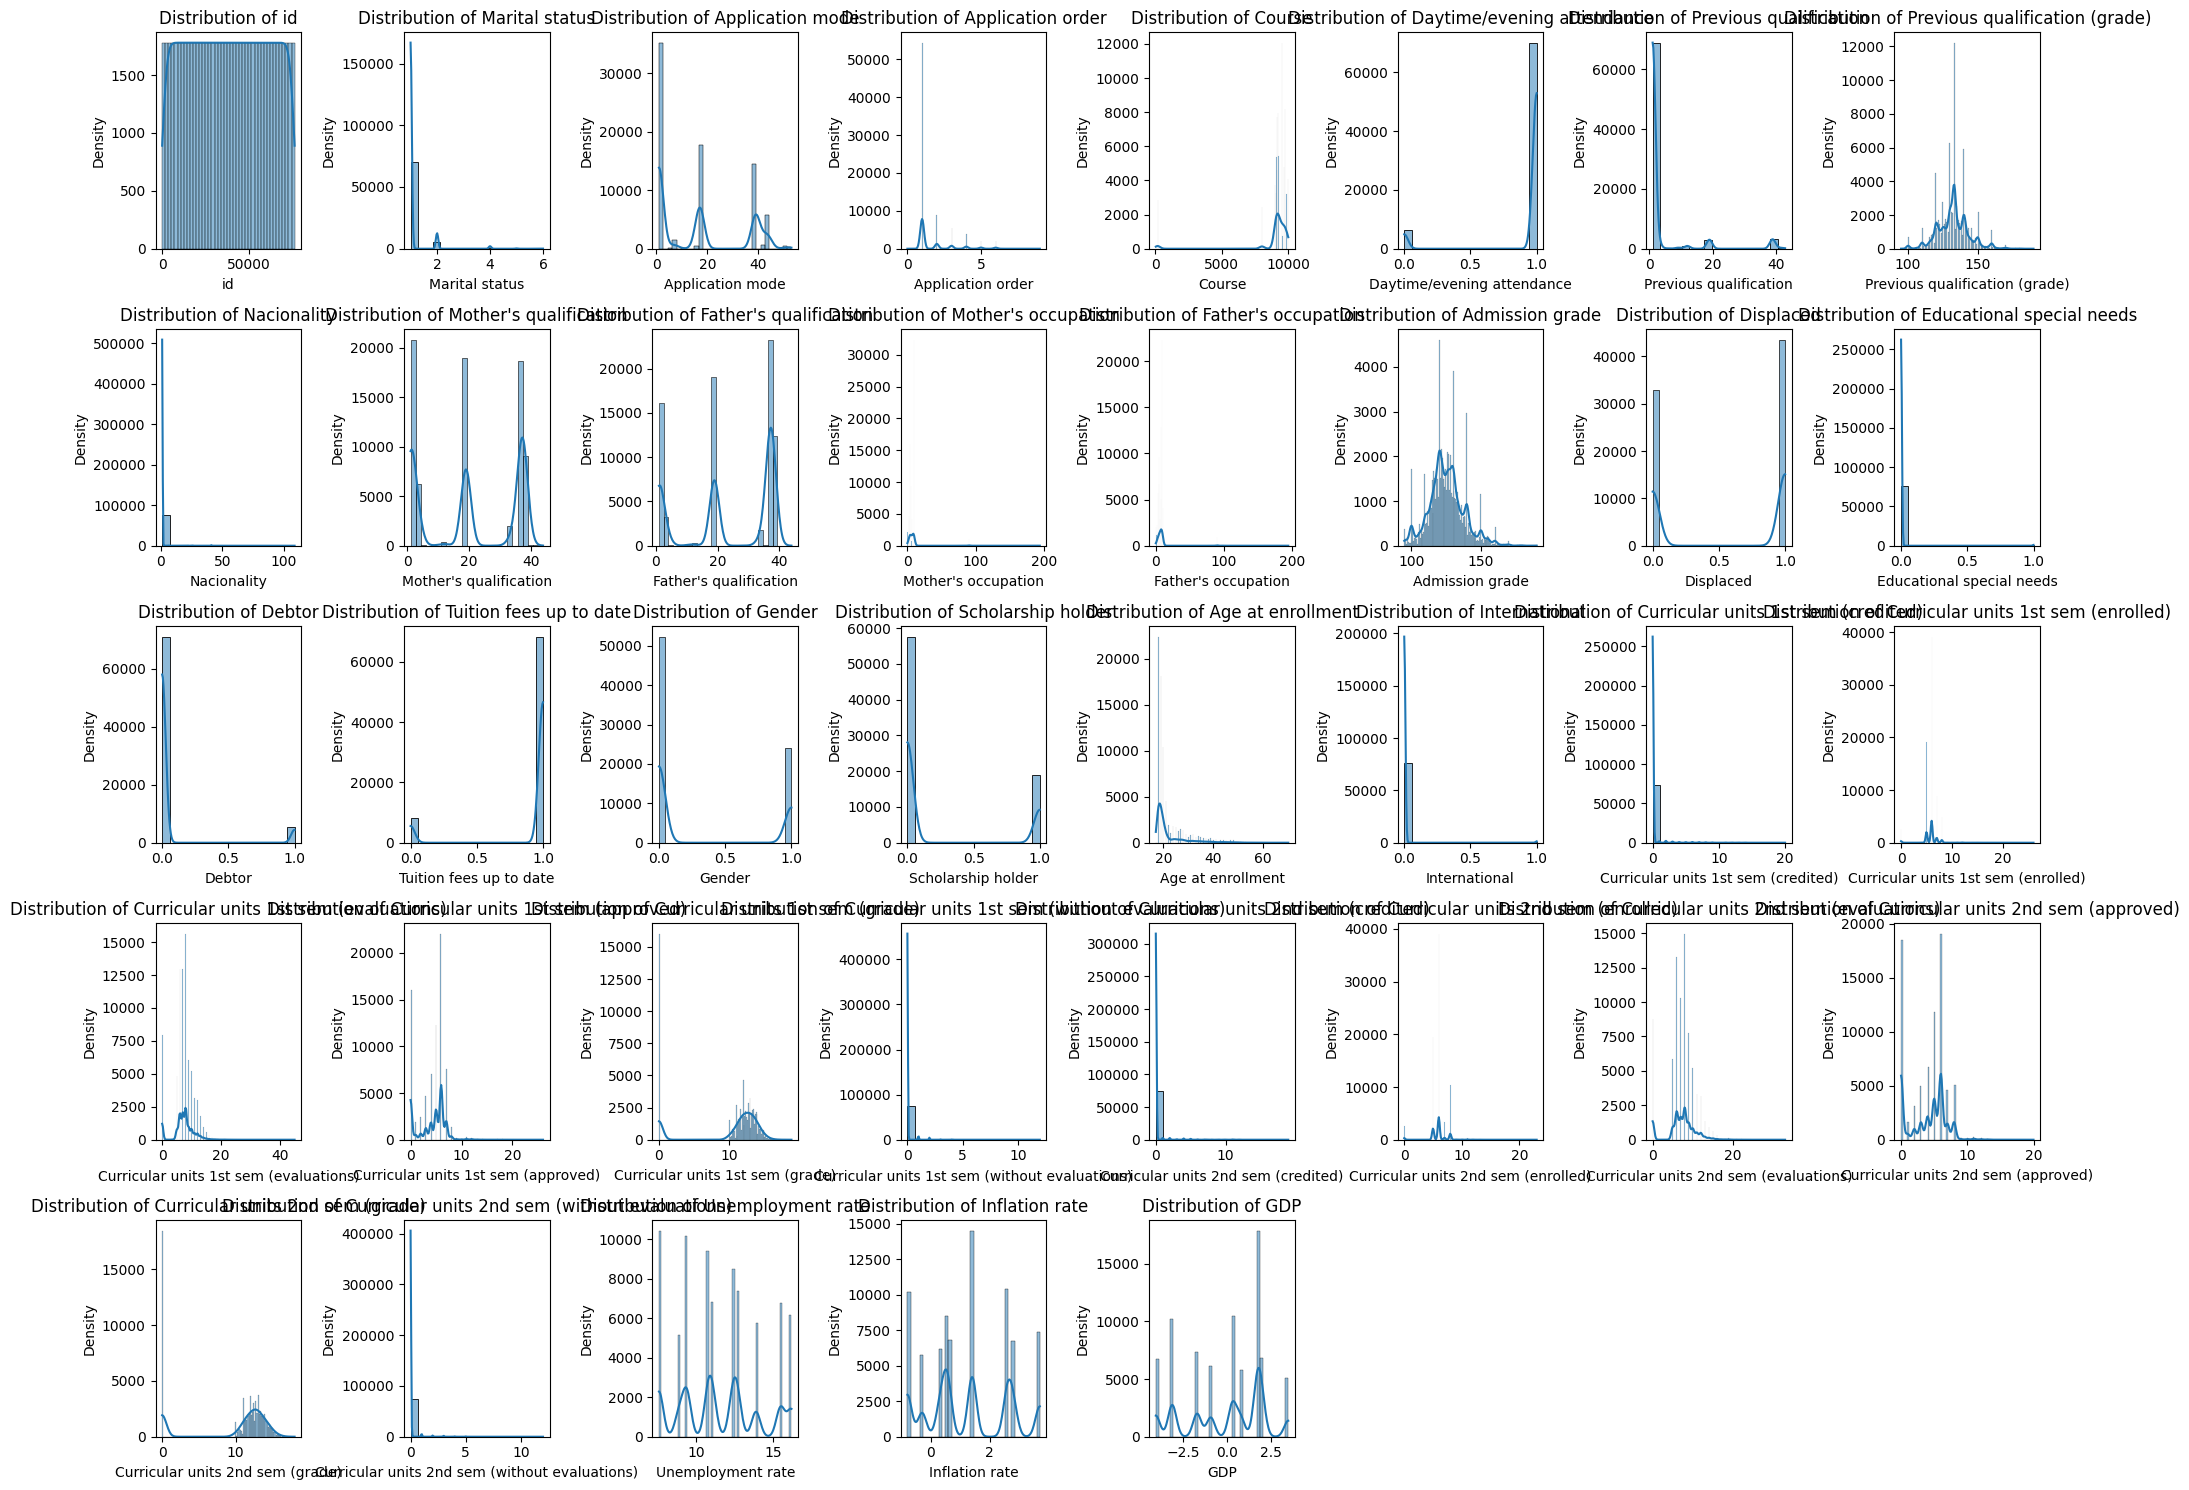

(                 id  Marital status  Application mode  Application order  \
 count  76518.000000    76518.000000      76518.000000       76518.000000   
 mean   38258.500000        1.111934         16.054419           1.644410   
 std    22088.988286        0.441669         16.682337           1.229645   
 min        0.000000        1.000000          1.000000           0.000000   
 25%    19129.250000        1.000000          1.000000           1.000000   
 50%    38258.500000        1.000000         17.000000           1.000000   
 75%    57387.750000        1.000000         39.000000           2.000000   
 max    76517.000000        6.000000         53.000000           9.000000   
 
              Course  Daytime/evening attendance  Previous qualification  \
 count  76518.000000                76518.000000            76518.000000   
 mean    9001.286377                    0.915314                3.658760   
 std     1803.438531                    0.278416                8.623774   
 

In [4]:
# Summary statistics
summary_statistics = data.describe()

# Check for missing values
missing_values = data.isnull().sum()

# Distribution of Target Variable
plt.figure(figsize=(8, 6))
sns.countplot(x='Target', data=data)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(16, 12))
correlation_matrix = data.drop('Target', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Distribution of Numerical Features
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(5, 8, i)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

summary_statistics, missing_values

In [4]:
data.nunique().sort_values()

Gender                                                2
International                                         2
Scholarship holder                                    2
Tuition fees up to date                               2
Debtor                                                2
Daytime/evening attendance                            2
Educational special needs                             2
Displaced                                             2
Target                                                3
Marital status                                        6
Application order                                     8
Unemployment rate                                    11
Curricular units 2nd sem (without evaluations)       11
GDP                                                  11
Curricular units 1st sem (without evaluations)       12
Inflation rate                                       13
Nacionality                                          18
Course                                          

In [5]:
from sklearn.preprocessing import LabelEncoder

# カテゴリカル変数のリスト
categorical_features = [
    'Marital status', 'Application mode', 'Course', 
    'Daytime/evening attendance', 'Nacionality', 
    'Mother\'s qualification', 'Father\'s qualification', 
    'Mother\'s occupation', 'Father\'s occupation', 
    'Gender', 'Target'
]

# エンコーディングの適用
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    data[feature] = le.fit_transform(data[feature])
    label_encoders[feature] = le

data.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,0,0,1,11,1,1,126.0,0,0,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,2
1,1,0,11,1,11,1,1,125.0,0,15,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,0
2,2,0,11,2,12,1,1,137.0,0,2,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,0
3,3,0,0,3,13,1,1,131.0,0,15,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,1
4,4,0,0,2,13,1,1,132.0,0,15,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,2


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,76518.0,38258.500000,22088.988286,0.00,19129.250000,38258.500000,57387.750000,76517.000
Marital status,76518.0,0.111934,0.441669,0.00,0.000000,0.000000,0.000000,5.000
Application mode,76518.0,7.447738,7.341272,0.00,0.000000,11.000000,16.000000,21.000
Application order,76518.0,1.644410,1.229645,0.00,1.000000,1.000000,2.000000,9.000
Course,76518.0,11.204409,4.209958,0.00,8.000000,12.000000,15.000000,18.000
Daytime/evening attendance,76518.0,0.915314,0.278416,0.00,1.000000,1.000000,1.000000,1.000
Previous qualification,76518.0,3.658760,8.623774,1.00,1.000000,1.000000,1.000000,43.000
Previous qualification (grade),76518.0,132.378766,10.995328,95.00,125.000000,133.100000,140.000000,190.000
Nacionality,76518.0,0.057686,0.770564,0.00,0.000000,0.000000,0.000000,17.000
Mother's qualification,76518.0,14.572584,11.510344,0.00,0.000000,15.000000,27.000000,34.000


In [7]:
from sklearn.preprocessing import StandardScaler

# 新しい特徴量の作成例
data['Total_curricular_units_approved'] = data['Curricular units 1st sem (approved)'] + data['Curricular units 2nd sem (approved)']
data['Total_curricular_units_grade'] = data['Curricular units 1st sem (grade)'] + data['Curricular units 2nd sem (grade)']
data['Economic_situation'] = data['Unemployment rate'] + data['Inflation rate'] - data['GDP']

# スケーリング対象の特徴量
features_to_scale = [
    'Previous qualification (grade)', 'Age at enrollment', 
    'Admission grade', 'Total_curricular_units_approved', 
    'Total_curricular_units_grade', 'Unemployment rate', 
    'Inflation rate', 'GDP'
]

scaler = StandardScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

data.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,Total_curricular_units_approved,Total_curricular_units_grade,Economic_situation
0,0,0,0,1,11,1,1,-0.580138,0,0,...,6,12.428571,0,-0.158418,-0.449110,0.933176,2,0.712376,0.695391,9.68
1,1,0,11,1,11,1,1,-0.671086,0,15,...,0,0.000000,0,-0.158418,-0.449110,0.933176,0,-0.781748,-0.763470,9.68
2,2,0,11,2,12,1,1,0.420293,0,2,...,0,0.000000,0,1.763675,-0.663578,-0.372698,0,-1.528810,-1.867472,17.42
3,3,0,0,3,13,1,1,-0.125396,0,15,...,7,12.820000,0,-0.158418,-0.449110,0.933176,1,1.085907,0.550983,9.68
4,4,0,0,2,13,1,1,-0.034448,0,15,...,6,12.933333,0,-1.477502,0.980680,0.178079,2,0.712376,0.594326,9.88


In [8]:
# 相互作用特徴量の再作成
data['Admission_grade_x_Total_units_approved'] = data['Admission grade'] * data['Total_curricular_units_approved']
data['Admission_grade_x_Total_units_grade'] = data['Admission grade'] * data['Total_curricular_units_grade']
data['Total_units_approved_x_Total_units_grade'] = data['Total_curricular_units_approved'] * data['Total_curricular_units_grade']
data['Unemployment_rate_x_Inflation_rate'] = data['Unemployment rate'] * data['Inflation rate']

# 相互作用特徴量の確認
interaction_features = data[['Admission_grade_x_Total_units_approved', 'Admission_grade_x_Total_units_grade', 'Total_units_approved_x_Total_units_grade', 'Unemployment_rate_x_Inflation_rate']]
interaction_features.head()

,Admission_grade_x_Total_units_approved,Admission_grade_x_Total_units_grade,Total_units_approved_x_Total_units_grade,Unemployment_rate_x_Inflation_rate
0,-0.156738,-0.153001,0.495379,0.071147
1,0.346246,0.338150,0.596841,0.071147
2,-2.353171,-2.874446,2.855010,-1.170336
3,0.063624,0.032282,0.598316,0.071147
4,-0.298508,-0.249041,0.423384,-1.448956


In [21]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# 特徴量と目的変数に分割
X = data.drop(['Target', 'id'], axis=1)
y = data['Target']

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoostのモデルの訓練
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# 予測
xgb_pred = xgb_model.predict(X_test)

# 評価
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_report = classification_report(y_test, xgb_pred)

print(xgb_accuracy)
print(xgb_report)

0.832723470987977
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      5028
           1       0.66      0.61      0.63      3017
           2       0.86      0.92      0.89      7259

    accuracy                           0.83     15304
   macro avg       0.80      0.79      0.80     15304
weighted avg       0.83      0.83      0.83     15304



In [22]:
# カテゴリカル変数のリスト
categorical_features_test = [
    'Marital status', 'Application mode', 'Course', 
    'Daytime/evening attendance', 'Nacionality', 
    'Mother\'s qualification', 'Father\'s qualification', 
    'Mother\'s occupation', 'Father\'s occupation', 
    'Gender'
]

# エンコーディングの適用
label_encoders = {}
for feature in categorical_features_test:
    le = LabelEncoder()
    test_df[feature] = le.fit_transform(test_df[feature])
    label_encoders[feature] = le

# 新しい特徴量の作成例
test_df['Total_curricular_units_approved'] = test_df['Curricular units 1st sem (approved)'] + test_df['Curricular units 2nd sem (approved)']
test_df['Total_curricular_units_grade'] = test_df['Curricular units 1st sem (grade)'] + test_df['Curricular units 2nd sem (grade)']
test_df['Economic_situation'] = test_df['Unemployment rate'] + test_df['Inflation rate'] - test_df['GDP']

test_df[features_to_scale] = scaler.fit_transform(test_df[features_to_scale])

# 相互作用特徴量の再作成
test_df['Admission_grade_x_Total_units_approved'] = test_df['Admission grade'] * test_df['Total_curricular_units_approved']
test_df['Admission_grade_x_Total_units_grade'] = test_df['Admission grade'] * test_df['Total_curricular_units_grade']
test_df['Total_units_approved_x_Total_units_grade'] = test_df['Total_curricular_units_approved'] * test_df['Total_curricular_units_grade']
test_df['Unemployment_rate_x_Inflation_rate'] = test_df['Unemployment rate'] * test_df['Inflation rate']

In [23]:
test_preprocessed = test_df.drop('id', axis=1)

# モデルの予測結果を取得
test_pred = xgb_model.predict(test_preprocessed)

In [24]:
# ターゲット値に変換
target_mapping = {0: 'Dropout', 1: 'Enrolled', 2: 'Graduate'}
inverse_target_mapping = {v: k for k, v in target_mapping.items()}
final_predictions = [target_mapping[pred] for pred in test_pred]

In [25]:
# 結果をデータフレームに格納
results_df = pd.DataFrame(data={"id":test_df.id, "Target": final_predictions})

print(results_df.head())

      id    Target
0  76518   Dropout
1  76519  Graduate
2  76520  Graduate
3  76521  Graduate
4  76522  Enrolled


In [26]:
# 結果を保存
results_df.to_csv('submission2.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
